In [2]:
import xml.etree.ElementTree as ET

In [3]:
tree = ET.parse('/home/jj/Downloads/bayes.xml')

In [4]:
root = tree.getroot()

In [5]:
from collections import defaultdict

variables = defaultdict(list)
for child in root.findall('.//VARIABLE'):
    for grandchild in child:
        if grandchild.tag == 'NAME':
            name = grandchild.text
        elif grandchild.tag == 'OUTCOME':
            value = grandchild.text.replace("'", '')
            variables[name].append(value)

In [6]:
for name in variables:
    print(name, len(variables[name]))

skill_ID 54
ability_profile 8
problem_difficulty 11
skill_mastery 52
correctness 2


In [7]:
import numpy as np

def values2matrix(value):
    t = []
    for line in value.splitlines():
        if line:
            t.append(list(map(float, line.split())))
    return np.array(t)

In [8]:
matrices = {}
for child in root.findall('.//DEFINITION'):
    y = ''
    x = []
    for grandchild in child:
        if grandchild.tag == 'FOR':
            y = grandchild.text
        elif grandchild.tag == 'GIVEN':
            x.append(grandchild.text)
        elif grandchild.tag == 'TABLE':
            matrices[f'{", ".join(x)} => {y}'] = values2matrix(grandchild.text)
        else:
            print(grandchild.tag, grandchild.text)

In [9]:
for name in matrices:
    print(name, matrices[name].shape)

correctness => skill_ID (2, 54)
correctness, skill_ID => ability_profile (108, 8)
correctness, skill_ID => problem_difficulty (108, 11)
correctness, skill_ID => skill_mastery (108, 52)
 => correctness (1, 2)


```
p(c,s,m)
= p(c|s,m) * p(s,m)
    want       ?
= p(m|c,s) * p(s,c)
    OK         inferred
52 x 2 x 54  2 x 54
    
p(s,m) = \sum p(s,m,c)

$p(s|c) * p(c) = p(s,c)$
   OK      OK
 2 x 54    2     2 x 54
 
p(s) = \sum p(s,c)
```

In [10]:
matrices['correctness => skill_ID'].sum(axis=1)

array([1., 1.])

In [11]:
pSC = matrices['correctness => skill_ID'] * matrices[' => correctness'].reshape(-1)[:, None]

In [12]:
pSC.sum(axis=1)

array([0.66068021, 0.33931979])

In [13]:
matrices[' => correctness']

array([[0.66068021, 0.33931979]])

In [14]:
pSC.sum(axis=0).sum()

0.9999999999999999

In [15]:
pSC.sum()

1.0

In [16]:
pSC.sum(axis=0)

array([0.01087894, 0.02373079, 0.00669274, 0.00614969, 0.00669803,
       0.01451691, 0.04603752, 0.04161626, 0.02681687, 0.02597898,
       0.00099965, 0.00911788, 0.02672019, 0.06692652, 0.0249901 ,
       0.05240111, 0.01558247, 0.00678419, 0.07563356, 0.01047826,
       0.01212127, 0.02198052, 0.03019566, 0.01105591, 0.00669279,
       0.01093963, 0.00234427, 0.00815438, 0.00978805, 0.02044825,
       0.00313585, 0.00066976, 0.00283624, 0.00739307, 0.06353655,
       0.02777602, 0.03587372, 0.00154241, 0.00143074, 0.00907718,
       0.00166944, 0.01291365, 0.00203456, 0.01103077, 0.00319168,
       0.03476201, 0.08725394, 0.02782669, 0.00333359, 0.00354185,
       0.01912345, 0.00032475, 0.00051751, 0.00673319])

In [17]:
pSC.shape

(2, 54)

In [45]:
# matrices['correctness => skill_ID'].T @ matrices[' => correctness'].T

In [69]:
LENGTH = 8
VARIABLE = 'ability_profile'

In [70]:
pCStoM = matrices[f'correctness, skill_ID => {VARIABLE}'].reshape(2, 54, LENGTH)

In [71]:
pCSM = pCStoM * pSC[:, :, None]

In [72]:
pCSM.sum()

1.0

In [73]:
pSM = pCSM.sum(axis=0)
pSM.shape

(54, 8)

In [74]:
pSMtoC = pCSM / pSM[None]

In [75]:
pSMtoC.shape

(2, 54, 8)

## Plot wrt skill mastery, problem difficulty

In [67]:
SKILL_ID = 18
this_slice = pSMtoC[0, SKILL_ID, :]

Text(0.5, 1.0, 'Skill 18')

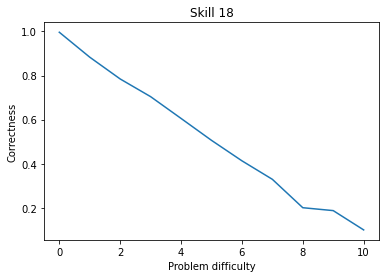

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(this_slice)
plt.xlabel('Problem difficulty')
plt.ylabel('Correctness')
plt.title(f'Skill {SKILL_ID}')

## Plot wrt ability profile

Text(0, 0.5, 'Correctness')

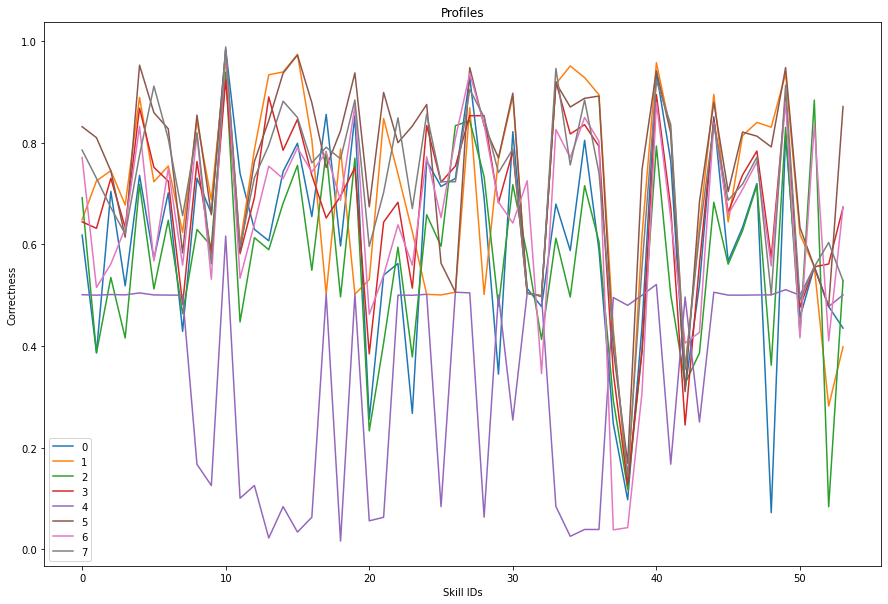

In [82]:
plt.figure(figsize=(15, 10))
for profile in range(LENGTH):
    plt.plot(pSMtoC[0, :, profile], label=profile)
plt.legend()
plt.title('Profiles')
plt.xlabel('Skill IDs')
plt.ylabel('Correctness')